# Configuração Drive

Necessário para rodar no ambiente Collab

In [1]:
import sys
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
project_path = '/content/drive/MyDrive/ml_challenge/yolo_project'

sys.path.append(project_path)
os.chdir(project_path)

Mounted at /content/drive


# Instalação Dependências Necessárias

In [2]:
#!pip install -r requirements.txt

# Bibliotecas

In [3]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from ultralytics import YOLO
import pandas as pd
import cv2
from PIL import Image
import yaml
import shutil
import time
from datetime import datetime

# importa funções criadas
from scripts.train import *
from scripts.display import *
from scripts.results import *

%matplotlib inline
plt.style.use('ggplot')

# Extração e Estrutura do Dataset

In [4]:
data_zip_path = 'data_train.zip'
extract_dir = './'

if os.path.exists(data_zip_path):
    print("Extraindo o dataset...")
    with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Dataset extraído com sucesso!")
else:
    print("Arquivo data_train.zip não encontrado.")

Extraindo o dataset...
Dataset extraído com sucesso!


In [5]:
dataset_info = display_dataset_info()

Estrutura do Dataset:
- Train images: 365
- Train labels: 365
- Validation images: 92
- Validation labels: 92

Proporções de Split:
- Train: 79.9% (365 images)
- Validation: 20.1% (92 images)


# Análise Exploratória do Dataset

In [6]:
yaml_config = read_yaml_config()

if yaml_config:
    print("\nArquivo de configuração YAML:")
    print(f"- Classes: {yaml_config['names']}")
    print(f"- Número de classes: {yaml_config['nc']}")


Arquivo de configuração YAML:
- Classes: ['person', 'car', 'motorcycle', 'bus', 'truck', 'van']
- Número de classes: 6



Visualizando amostras do dataset:


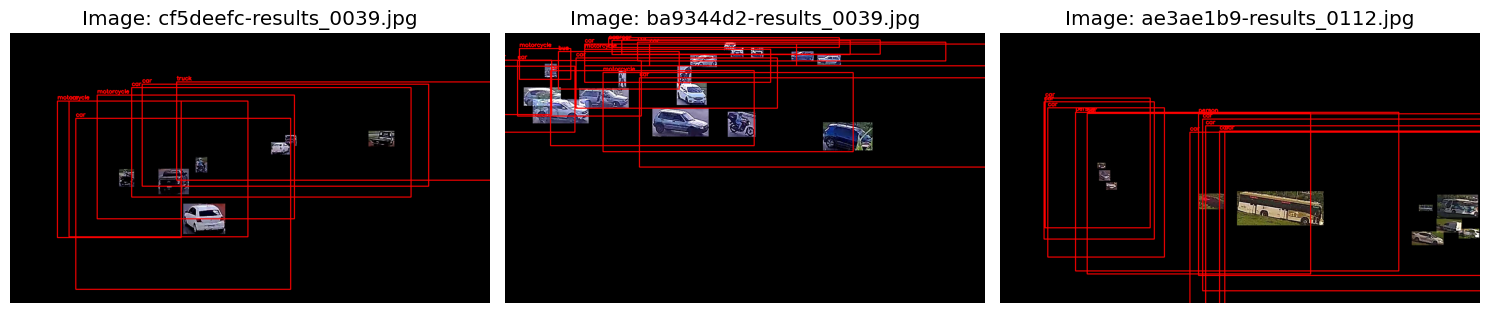

In [7]:
print("\nVisualizando amostras do dataset:")
visualize_dataset_samples(3)

# Análise da distribuição de classes nos dados de treinamento


Analisando a distribuição de classes no dataset:


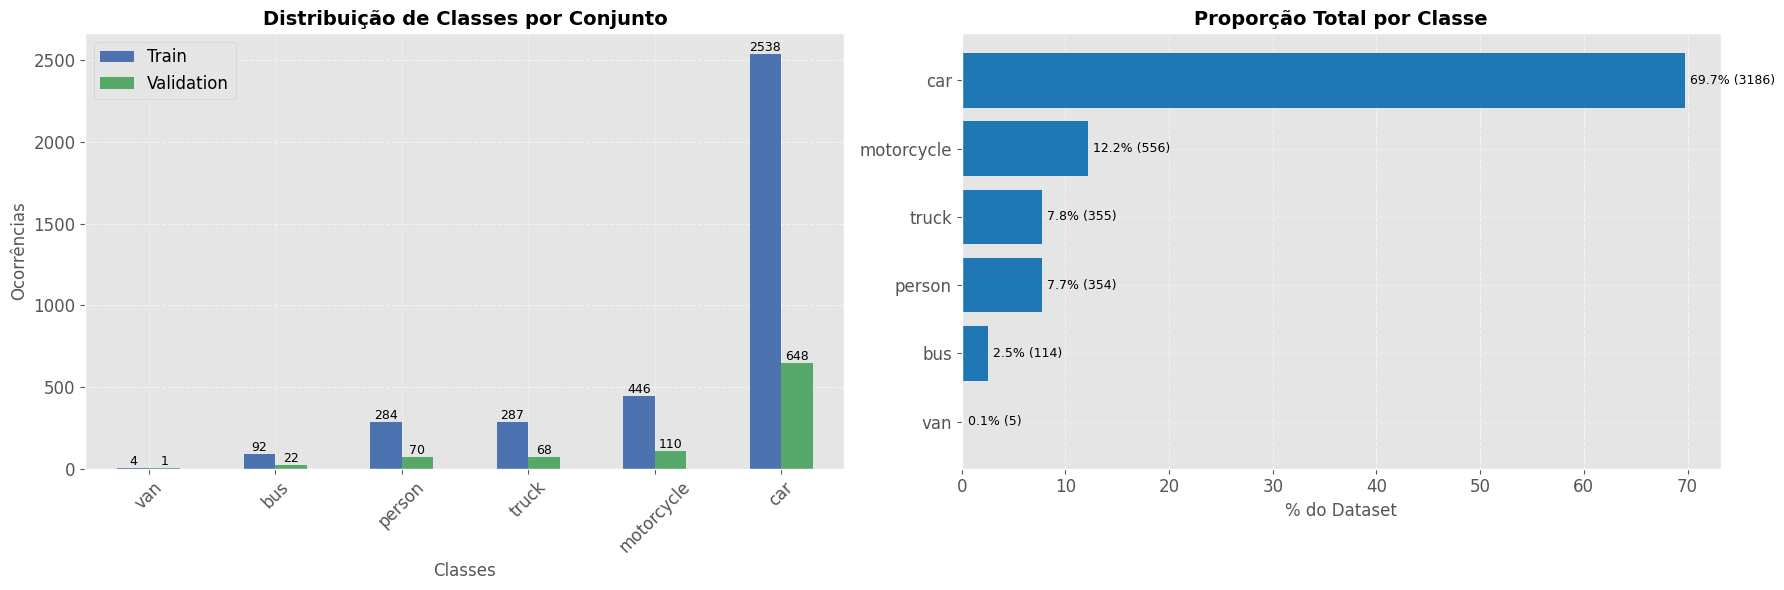

In [8]:
print("\nAnalisando a distribuição de classes no dataset:")
class_distribution = analyze_class_distribution()

# Configuração Treinamento

In [9]:
# definição os tamanhos de imagem para os três modelos
image_sizes = [256, 512, 640]

# criação de configurações para cada modelo
model_configs = create_model_configs()
print("\nArquivos de configuração criados para cada modelo:")
for i, config in enumerate(model_configs):
    print(f"- Modelo {i+1} ({image_sizes[i]}px): {config}")


Arquivos de configuração criados para cada modelo:
- Modelo 1 (256px): ./yaml/data_256.yaml
- Modelo 2 (512px): ./yaml/data_512.yaml
- Modelo 3 (640px): ./yaml/data_640.yaml


In [10]:
# verifica caminho do dataset que queremos verificar
dataset_base = "/content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset"
train_dir = os.path.join(dataset_base, "train")
val_dir = os.path.join(dataset_base, "val")

# verifica se os diretórios existem
print(f"Dataset base existe? {os.path.exists(dataset_base)}")
print(f"Diretório de treino existe? {os.path.exists(train_dir)}")
print(f"Diretório de validação existe? {os.path.exists(val_dir)}")

# se o diretório base existir lista seu conteúdo
if os.path.exists(dataset_base):
    print(f"Conteúdo do diretório do dataset: {os.listdir(dataset_base)}")

    # verifica se há imagens no diretório de treino
    if os.path.exists(train_dir):
        train_files = os.listdir(train_dir)
        print(f"Número de arquivos no diretório de treino: {len(train_files)}")
        if len(train_files) > 0:
            print(f"Primeiros 5 arquivos no diretório de treino: {train_files[:5]}")

    # verifica se há imagens no diretório de validação
    if os.path.exists(val_dir):
        val_files = os.listdir(val_dir)
        print(f"Número de arquivos no diretório de validação: {len(val_files)}")
        if len(val_files) > 0:
            print(f"Primeiros 5 arquivos no diretório de validação: {val_files[:5]}")

Dataset base existe? True
Diretório de treino existe? True
Diretório de validação existe? True
Conteúdo do diretório do dataset: ['train', 'val']
Número de arquivos no diretório de treino: 3
Primeiros 5 arquivos no diretório de treino: ['images', 'labels', 'labels.cache']
Número de arquivos no diretório de validação: 3
Primeiros 5 arquivos no diretório de validação: ['images', 'labels', 'labels.cache']


# Treinamento dos Modelos

In [11]:
def train_all_image_sizes(model_path='yolo11n.pt', epochs=50, batch_size=16, force_cpu=True):
    """
    Treina o modelo para todos os tamanhos de imagem definidos
    e gera um relatório comparativo ao final.
    """
    image_sizes = [256, 512, 640]
    results = []

    print(f"\n{'='*80}")
    print(f"INICIANDO TREINAMENTO PARA TODOS OS TAMANHOS DE IMAGEM")
    print(f"{'='*80}")

    for img_size in image_sizes:
        print(f"\n{'*'*80}")
        print(f"TREINANDO MODELO COM IMAGENS DE {img_size}px")
        print(f"{'*'*80}")

        try:
            result = train_model(
                img_size=img_size,
                epochs=epochs,
                batch_size=batch_size,
                model_path=model_path,
                force_cpu=force_cpu
            )

            # verifica se o resultado não é None antes de desempacotar
            if result is not None:
                model, save_dir = result

                if model is not None and save_dir is not None:
                    results.append({
                        'img_size': img_size,
                        'model': model,
                        'save_dir': save_dir
                    })
                    print(f"Treinamento com imagens de {img_size}px concluído com sucesso!")
                else:
                    print(f"Aviso: Modelo ou diretório de salvamento é None para o tamanho {img_size}px.")
            else:
                print(f"Aviso: train_model() retornou None para o tamanho {img_size}px.")

        except Exception as e:
            print(f"Erro durante o treinamento com imagens de {img_size}px: {e}")
            import traceback
            traceback.print_exc()
            continue

    # gera relatório comparativo
    if results:
        print(f"\n{'='*80}")
        print(f"RELATÓRIO COMPARATIVO DOS MODELOS")
        print(f"{'='*80}")

        # tenta carregar dados do arquivo consolidado
        consolidated_path = "/content/drive/MyDrive/ml_challenge/yolo_project/results/consolidated_metrics.csv"

        if os.path.exists(consolidated_path):
            df = pd.read_csv(consolidated_path)

            # filtra apenas os registros recentes
            recent_results = df[df['img_size'].isin([r['img_size'] for r in results])]

            if not recent_results.empty:
                print("\nComparando métricas entre os modelos:")
                for _, row in recent_results.iterrows():
                    print(f"F1-score calculado para modelo {int(row['img_size'])}px: {row['f1_score']:.4f}")

                # encontra o melhor modelo
                best_idx = recent_results['f1_score'].idxmax()
                best_model = recent_results.loc[best_idx]

                print(f"\nMelhor modelo: {int(best_model['img_size'])}px")
                print(f"F1-score: {best_model['f1_score']:.4f}")
                print(f"Precision: {best_model['precision']:.4f}")
                print(f"Recall: {best_model['recall']:.4f}")
                print(f"mAP50: {best_model['map50']:.4f}")
                print(f"mAP50-95: {best_model['map50_95']:.4f}")
        else:
            print("Arquivo consolidado de métricas não encontrado.")
            print("Verifique os diretórios individuais para cada tamanho de imagem.")
    else:
        print("Nenhum modelo foi treinado com sucesso.")

    return results

In [12]:
# verifica se quer executar o treinamento ou apenas carregar resultados existentes
RUN_TRAINING = False # mude para True se quiser executar o treinamento

if RUN_TRAINING:
    results = train_all_image_sizes(
        model_path='/content/drive/MyDrive/ml_challenge/yolo_project/yolo11n.pt',
        epochs=50,
        batch_size=16,
        force_cpu=False
    )

    models = [r['model'] for r in results]
    results_dirs = [r['save_dir'] for r in results]

else:
    # diretório base para os resultados
    base_dir = '/content/drive/MyDrive/ml_challenge/yolo_project/results/'

    # usa o arquivo consolidado para análise
    consolidated_path = os.path.join(base_dir, "consolidated_metrics.csv")

    if os.path.exists(consolidated_path):
        df = pd.read_csv(consolidated_path)

        print("\nComparando métricas entre os modelos:")
        for img_size in sorted(df['img_size'].unique()):
            # filtra registros para esse tamanho de imagem e pega o mais recente
            size_records = df[df['img_size'] == img_size].sort_values('timestamp', ascending=False)
            if not size_records.empty:
                latest = size_records.iloc[0]
                print(f"F1-score calculado para modelo {int(img_size)}px: {latest['f1_score']:.4f}")

        best_idx = df['f1_score'].idxmax()
        best_model = df.loc[best_idx]

        print(f"\nMelhor modelo: {int(best_model['img_size'])}px (timestamp: {best_model['timestamp']})")
        print(f"F1-score: {best_model['f1_score']:.4f}")
        print(f"Precision: {best_model['precision']:.4f}")
        print(f"Recall: {best_model['recall']:.4f}")

    else:
        print("Arquivo consolidado não encontrado.")


INICIANDO TREINAMENTO PARA TODOS OS TAMANHOS DE IMAGEM

********************************************************************************
TREINANDO MODELO COM IMAGENS DE 256px
********************************************************************************

iniciando treinamento do modelo yolo11n com imgsz=256
copiando modelo de /content/drive/MyDrive/ml_challenge/yolo_project/yolo11n.pt para /content/yolo11n.pt...
usando dispositivo: cuda:0
diretório de treino: /content/dataset/train
diretório de validação: /content/dataset/val
usando dataset em: /content/dataset
iniciando treinamento...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/yolo11n.pt, data=/content/dataset_config.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=256, save=True, save_period=10, cache=False, device=cuda:0, workers=0, project=/content/yolo_outputs, name=train_yolo11n_imgsz256_20250412_012522, exist_ok=True, pretr

train: Scanning /content/dataset/train/labels.cache... 365 images, 0 backgrounds, 0 corrupt: 100%|██████████| 365/365 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/train/images/13813ee3-results_0078.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/val/labels.cache... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]

Plotting labels to /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522/labels.jpg... 


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.475G       2.03      3.384      0.981        210        256: 100%|██████████| 23/23 [00:09<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         92        919    0.00263      0.112      0.041     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.486G      1.474      1.947     0.8706        171        256: 100%|██████████| 23/23 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

                   all         92        919     0.0555      0.218      0.112     0.0556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.502G      1.428      1.733     0.8555        213        256: 100%|██████████| 23/23 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

                   all         92        919     0.0177      0.485      0.152     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.502G      1.295      1.478     0.8452        174        256: 100%|██████████| 23/23 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

                   all         92        919      0.511      0.137      0.199      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.502G       1.25      1.359     0.8367        220        256: 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         92        919      0.508      0.165      0.231      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.502G      1.251      1.306      0.841        221        256: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

                   all         92        919      0.429       0.21      0.255      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.537G      1.194      1.255      0.831        255        256: 100%|██████████| 23/23 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

                   all         92        919      0.422      0.292      0.269      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.553G      1.207      1.219     0.8272        314        256: 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         92        919      0.451      0.311      0.312      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.553G      1.147      1.168     0.8247        297        256: 100%|██████████| 23/23 [00:06<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

                   all         92        919      0.485      0.309      0.351      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.553G      1.119      1.099     0.8286        228        256: 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         92        919      0.497      0.357      0.381      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.566G       1.12      1.053      0.827        246        256: 100%|██████████| 23/23 [00:07<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         92        919      0.665      0.411      0.425      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.566G      1.121      1.026     0.8223        219        256: 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         92        919      0.735      0.376      0.426      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.566G      1.124      1.012     0.8295        265        256: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]

                   all         92        919      0.732      0.385      0.441      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.582G      1.038     0.9619     0.8217        239        256: 100%|██████████| 23/23 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         92        919      0.602      0.479       0.44       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.596G      1.064     0.9561     0.8224        155        256: 100%|██████████| 23/23 [00:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         92        919      0.612      0.478      0.443      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.596G      1.086     0.9353     0.8178        232        256: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         92        919      0.631      0.509      0.483      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.596G      1.078     0.9291     0.8236        273        256: 100%|██████████| 23/23 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         92        919      0.649      0.481      0.489      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.611G      1.028     0.8804     0.8181        198        256: 100%|██████████| 23/23 [00:07<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

                   all         92        919      0.684      0.468      0.495      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.611G      1.029     0.8847     0.8166        191        256: 100%|██████████| 23/23 [00:07<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         92        919      0.661      0.518       0.49      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.611G      1.016      0.895     0.8204        266        256: 100%|██████████| 23/23 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         92        919      0.682      0.509        0.5      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.611G     0.9841     0.8587     0.8122        209        256: 100%|██████████| 23/23 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

                   all         92        919      0.703      0.524      0.498      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.611G     0.9714     0.8286     0.8161        292        256: 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         92        919      0.663      0.522      0.509      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.611G     0.9567     0.8427     0.8099        223        256: 100%|██████████| 23/23 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         92        919      0.684      0.495      0.516      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.611G     0.9766     0.8164     0.8138        200        256: 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         92        919      0.697      0.507      0.501      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.611G     0.9469     0.8301     0.8045        258        256: 100%|██████████| 23/23 [00:06<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         92        919      0.693      0.508      0.504      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.611G     0.9468     0.8026      0.816        190        256: 100%|██████████| 23/23 [00:07<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

                   all         92        919      0.743      0.486      0.507      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.611G      0.957     0.8142     0.8136        212        256: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         92        919      0.759       0.49      0.514      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.611G       1.01      0.811     0.8115        180        256: 100%|██████████| 23/23 [00:06<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         92        919       0.75      0.511      0.531      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.611G     0.9539     0.7732     0.8116        237        256: 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]

                   all         92        919      0.772      0.528      0.536      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.635G     0.9644     0.7711     0.8098        206        256: 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         92        919      0.738       0.53      0.532      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.635G     0.9799     0.7879     0.8058        209        256: 100%|██████████| 23/23 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

                   all         92        919      0.776      0.545      0.539      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.635G     0.9467     0.7545     0.8102        229        256: 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         92        919      0.773      0.539      0.536      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.635G     0.8955     0.7408     0.8101        178        256: 100%|██████████| 23/23 [00:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         92        919      0.774      0.536      0.538      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.635G     0.8846     0.7454     0.8105        215        256: 100%|██████████| 23/23 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         92        919      0.716      0.539      0.522      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.635G     0.8751      0.714     0.8055        169        256: 100%|██████████| 23/23 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]

                   all         92        919      0.747      0.543      0.533      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.635G     0.8953     0.7224     0.8099        216        256: 100%|██████████| 23/23 [00:06<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

                   all         92        919      0.755      0.543      0.538      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.648G     0.8888     0.7187      0.807        219        256: 100%|██████████| 23/23 [00:07<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         92        919      0.769      0.523      0.536      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.664G     0.9131     0.7407     0.8055        268        256: 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         92        919      0.764       0.53      0.538       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.664G     0.8757     0.7019     0.7995        218        256: 100%|██████████| 23/23 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         92        919      0.735      0.545      0.531      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.664G     0.8666     0.7283     0.8053        233        256: 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         92        919      0.747      0.549      0.541       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.664G     0.8559     0.8033     0.8002        131        256: 100%|██████████| 23/23 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         92        919      0.774      0.533      0.538      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.664G     0.8656     0.7411     0.7933        151        256: 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         92        919      0.793      0.511      0.546      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.664G     0.8529     0.7226     0.8009        137        256: 100%|██████████| 23/23 [00:04<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

                   all         92        919       0.79      0.511      0.555      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.664G     0.8363     0.7028     0.7963        119        256: 100%|██████████| 23/23 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         92        919      0.769      0.525      0.554      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.664G     0.8119     0.6913     0.7993        126        256: 100%|██████████| 23/23 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         92        919      0.784      0.543       0.55      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.664G     0.8234     0.6836      0.795        121        256: 100%|██████████| 23/23 [00:05<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         92        919      0.784      0.542      0.552      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.664G     0.8057     0.6733      0.792        122        256: 100%|██████████| 23/23 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         92        919      0.784      0.541      0.551      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.664G     0.8048     0.6612     0.7957         96        256: 100%|██████████| 23/23 [00:05<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

                   all         92        919       0.79      0.533      0.551      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.664G     0.7833     0.6582     0.7976        134        256: 100%|██████████| 23/23 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all         92        919      0.798      0.539      0.556      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.664G     0.7977     0.6675     0.7967         95        256: 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         92        919      0.795      0.545      0.561      0.409



50 epochs completed in 0.113 hours.
Optimizer stripped from /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522/weights/last.pt, 5.4MB
Optimizer stripped from /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522/weights/best.pt, 5.4MB

Validating /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


                   all         92        919      0.782       0.54      0.551      0.411
                person         41         70      0.876      0.911      0.924      0.818
                   car         92        648       0.82      0.725      0.797      0.573
            motorcycle         50        110      0.507      0.373      0.405      0.234
                   bus         16         22      0.789      0.364      0.373      0.181
                 truck         39         68      0.697      0.868      0.808      0.657
                   van          1          1          1          0          0          0
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522

treinamento concluído em 0h 7m 2s
resultados salvos em: /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522
resumo da última época salvo em: /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522/resul

val: Scanning /content/dataset/val/labels.cache... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


                   all         92        919      0.784      0.541      0.551      0.409
                person         41         70      0.876      0.908      0.925      0.814
                   car         92        648      0.822      0.725      0.798      0.573
            motorcycle         50        110      0.517       0.38      0.405      0.236
                   bus         16         22      0.794      0.364      0.373      0.167
                 truck         39         68      0.698      0.868      0.809      0.662
                   van          1          1          1          0          0          0
Speed: 0.0ms preprocess, 1.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522
mAP50-95: 0.40880868275452775
mAP50: 0.5514687534294097
precision: 0.7951
recall: 0.5451
f1-score: 0.6468
métricas finais salvas em: /content/yolo_outputs/train_yolo11n_imgsz256_20250412_012522/metrics_summary_256px.c

train: Scanning /content/dataset/train/labels.cache... 365 images, 0 backgrounds, 0 corrupt: 100%|██████████| 365/365 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/train/images/13813ee3-results_0078.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/val/labels.cache... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]

Plotting labels to /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230/labels.jpg... 


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.69G      1.343      2.957     0.9303        217        512: 100%|██████████| 23/23 [00:11<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         92        919    0.00321      0.137     0.0813     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.71G     0.8806      1.677     0.8445        175        512: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         92        919     0.0242      0.422      0.176      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.72G      0.863      1.427     0.8422        214        512: 100%|██████████| 23/23 [00:09<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         92        919     0.0302      0.608      0.226      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.8G     0.7692      1.209      0.832        181        512: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         92        919      0.746      0.186      0.288      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       1.8G     0.7593      1.143      0.827        231        512: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         92        919        0.5      0.271      0.351      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       1.8G     0.7248      1.027     0.8252        228        512: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         92        919      0.574      0.392      0.442       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.89G     0.6822     0.9628     0.8171        265        512: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         92        919      0.656      0.542      0.519      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.99G     0.6903     0.9286      0.814        326        512: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         92        919      0.713      0.565      0.552      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.99G     0.6616     0.8771     0.8128        304        512: 100%|██████████| 23/23 [00:09<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         92        919      0.783      0.524      0.573      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.99G     0.6304     0.8355     0.8113        241        512: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         92        919      0.777       0.56      0.598      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         2G     0.6072     0.7756     0.8057        252        512: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         92        919      0.789      0.563      0.624      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         2G     0.6083     0.7519     0.8072        229        512: 100%|██████████| 23/23 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         92        919      0.804      0.598      0.638      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         2G     0.5967     0.7398     0.8069        270        512: 100%|██████████| 23/23 [00:09<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         92        919      0.817      0.631       0.65      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.02G     0.5691     0.7108     0.8036        241        512: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         92        919      0.812      0.635      0.651      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.03G     0.5667     0.6974     0.8033        157        512: 100%|██████████| 23/23 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         92        919      0.794      0.643      0.651      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.03G     0.5661     0.6763     0.8031        241        512: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         92        919      0.794      0.646      0.655      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.03G     0.5593     0.6591     0.8054        281        512: 100%|██████████| 23/23 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         92        919      0.777      0.639      0.647      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.04G      0.546     0.6389     0.8003        199        512: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         92        919      0.831      0.624      0.648      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.04G     0.5451     0.6301     0.7995        193        512: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         92        919      0.798       0.63      0.651      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.13G     0.5561     0.6515     0.8018        279        512: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

                   all         92        919      0.805      0.623      0.653      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.14G     0.5345     0.6228     0.7997        214        512: 100%|██████████| 23/23 [00:09<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         92        919      0.813      0.632      0.667      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.14G     0.5504     0.6053     0.7999        304        512: 100%|██████████| 23/23 [00:10<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         92        919       0.82      0.632      0.669      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.23G     0.5363     0.6107     0.7979        231        512: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         92        919       0.82      0.639      0.675      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.23G     0.5173     0.5868     0.7982        204        512: 100%|██████████| 23/23 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         92        919      0.792       0.67      0.674      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.23G     0.5145     0.5965     0.7916        268        512: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         92        919      0.764      0.663      0.669      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.23G     0.4857       0.56     0.7947        195        512: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         92        919      0.837      0.651      0.677      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.23G     0.4996     0.5697     0.7973        221        512: 100%|██████████| 23/23 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         92        919      0.816       0.63      0.663      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.23G     0.5218     0.5669     0.7987        183        512: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         92        919      0.876      0.611      0.681      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.23G     0.5073     0.5528     0.7981        248        512: 100%|██████████| 23/23 [00:10<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         92        919      0.804      0.656      0.686      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.32G     0.4953     0.5482     0.7986        212        512: 100%|██████████| 23/23 [00:10<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         92        919      0.834      0.667      0.687      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.32G     0.5122     0.5386     0.7964        219        512: 100%|██████████| 23/23 [00:09<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         92        919      0.786      0.695      0.679      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.32G     0.4889     0.5374     0.7962        239        512: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         92        919      0.859      0.608      0.687      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.32G      0.475     0.5292     0.7926        182        512: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

                   all         92        919      0.825      0.676      0.695       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.32G     0.4794     0.5209     0.7968        225        512: 100%|██████████| 23/23 [00:10<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         92        919      0.825      0.698      0.694      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.32G     0.4807     0.5117     0.7913        172        512: 100%|██████████| 23/23 [00:09<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

                   all         92        919      0.789      0.691      0.689      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.32G     0.4808     0.5214     0.7945        219        512: 100%|██████████| 23/23 [00:10<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         92        919      0.822      0.671        0.7      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.32G     0.4874     0.5207     0.7975        223        512: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         92        919      0.821      0.687      0.685       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.32G     0.4872     0.5186     0.7933        282        512: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         92        919      0.841      0.694      0.691      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.32G     0.4612     0.4926     0.7906        224        512: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         92        919      0.807      0.682      0.693      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.32G     0.4597     0.5143     0.7938        243        512: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         92        919      0.826      0.673      0.712      0.626


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.32G     0.4637     0.5526     0.7851        131        512: 100%|██████████| 23/23 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         92        919      0.857       0.66      0.743       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.32G     0.4657     0.5279     0.7877        156        512: 100%|██████████| 23/23 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         92        919      0.867      0.658      0.719      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.32G     0.4415     0.5043     0.7844        140        512: 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         92        919      0.869      0.661      0.715      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.32G     0.4374     0.4855     0.7837        122        512: 100%|██████████| 23/23 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         92        919      0.847      0.693      0.713      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.32G     0.4209     0.4854     0.7833        126        512: 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         92        919       0.82      0.701      0.707      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.32G     0.4292      0.473     0.7839        122        512: 100%|██████████| 23/23 [00:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         92        919      0.827      0.699      0.704      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.32G     0.4252     0.4753     0.7844        122        512: 100%|██████████| 23/23 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         92        919      0.827      0.687      0.701      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.32G     0.4239      0.468     0.7854         96        512: 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         92        919      0.828      0.689      0.699       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.32G     0.4176     0.4644      0.783        135        512: 100%|██████████| 23/23 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         92        919      0.843      0.678        0.7      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.32G     0.4167     0.4657     0.7795         99        512: 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         92        919      0.842      0.688      0.701       0.62



50 epochs completed in 0.151 hours.
Optimizer stripped from /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230/weights/last.pt, 5.4MB
Optimizer stripped from /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230/weights/best.pt, 5.4MB

Validating /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


                   all         92        919      0.857       0.66      0.743      0.656
                person         41         70      0.914      0.916       0.93      0.896
                   car         92        648      0.947      0.944      0.958      0.848
            motorcycle         50        110      0.786      0.702      0.802      0.656
                   bus         16         22      0.673      0.562      0.591      0.444
                 truck         39         68      0.824      0.838      0.848      0.791
                   van          1          1          1          0      0.332      0.298
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230

treinamento concluído em 0h 9m 14s
resultados salvos em: /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230
resumo da última época salvo em: /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230/resu

val: Scanning /content/dataset/val/labels.cache... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


                   all         92        919      0.857      0.661      0.743      0.651
                person         41         70      0.914      0.916       0.93      0.897
                   car         92        648      0.947      0.944      0.958      0.855
            motorcycle         50        110      0.786      0.701      0.802       0.66
                   bus         16         22      0.673      0.563      0.591      0.435
                 truck         39         68      0.824      0.838      0.848      0.793
                   van          1          1          1          0      0.332      0.265
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230
mAP50-95: 0.651077391080254
mAP50: 0.7432174718298324
precision: 0.8419
recall: 0.6880
f1-score: 0.7572
métricas finais salvas em: /content/yolo_outputs/train_yolo11n_imgsz512_20250412_013230/metrics_summary_512px.csv

train: Scanning /content/dataset/train/labels.cache... 365 images, 0 backgrounds, 0 corrupt: 100%|██████████| 365/365 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/train/images/13813ee3-results_0078.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/val/labels.cache... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]

Plotting labels to /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149/labels.jpg... 


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.68G       1.26      2.895     0.9349        218        640: 100%|██████████| 23/23 [00:13<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         92        919    0.00318      0.136     0.0831     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.68G     0.7825      1.595     0.8461        175        640: 100%|██████████| 23/23 [00:12<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         92        919     0.0333      0.389      0.227      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.68G     0.7433      1.322     0.8408        214        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         92        919      0.083      0.559      0.265       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.8G     0.6542      1.092     0.8235        182        640: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         92        919      0.558      0.271      0.429      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.8G     0.6469      1.009     0.8204        231        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         92        919      0.568      0.285       0.42      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.8G      0.624      0.912     0.8163        229        640: 100%|██████████| 23/23 [00:12<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         92        919      0.687       0.49      0.547       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.94G     0.5852       0.84     0.8164        267        640: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         92        919      0.701      0.544      0.554      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.08G     0.5899     0.8024     0.8125        327        640: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         92        919      0.704      0.597      0.599      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.08G     0.5662     0.7695     0.8089        305        640: 100%|██████████| 23/23 [00:12<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         92        919      0.761      0.585      0.595      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.08G       0.54     0.7382     0.8068        241        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         92        919        0.8      0.553      0.605      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       3.1G     0.5155     0.6812     0.8067        252        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         92        919      0.753       0.62      0.616      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.11G     0.5102     0.6648     0.8022        229        640: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         92        919      0.783      0.613      0.631      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.11G        0.5      0.658      0.803        270        640: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         92        919      0.821      0.597      0.634      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.11G     0.4777     0.6407     0.8026        241        640: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         92        919      0.833      0.609       0.65      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.12G     0.4777     0.6167      0.801        158        640: 100%|██████████| 23/23 [00:12<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         92        919      0.765      0.669      0.652      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.12G     0.4866     0.6233     0.7998        241        640: 100%|██████████| 23/23 [00:12<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         92        919      0.711      0.645      0.646      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.12G     0.4799     0.6015     0.7982        281        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         92        919      0.776      0.633      0.653       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.14G     0.4719     0.5807     0.8004        199        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         92        919      0.804      0.654      0.662      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.14G     0.4741     0.5597      0.799        194        640: 100%|██████████| 23/23 [00:12<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         92        919      0.756      0.653      0.654      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.27G     0.4772     0.5737      0.799        279        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         92        919      0.752      0.654      0.661      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.29G     0.4505     0.5654     0.7961        215        640: 100%|██████████| 23/23 [00:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         92        919      0.817      0.635       0.68       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.3G     0.4493     0.5471     0.7956        304        640: 100%|██████████| 23/23 [00:12<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         92        919      0.839       0.62      0.678      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.43G     0.4413     0.5408     0.7947        231        640: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         92        919      0.788       0.68      0.677      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.43G     0.4386     0.5296     0.7921        205        640: 100%|██████████| 23/23 [00:12<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         92        919      0.835      0.635      0.686       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.43G      0.429     0.5335     0.7915        267        640: 100%|██████████| 23/23 [00:12<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         92        919      0.859      0.676      0.694       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.43G     0.4154     0.5214     0.7935        194        640: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         92        919      0.794      0.659      0.694      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.43G     0.4261       0.53     0.7892        221        640: 100%|██████████| 23/23 [00:12<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         92        919      0.807      0.699      0.697      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.43G     0.4418      0.531     0.7922        183        640: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         92        919       0.76       0.71      0.697      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.43G     0.4286     0.5081     0.7913        250        640: 100%|██████████| 23/23 [00:12<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         92        919      0.843      0.687      0.703      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.58G     0.4181     0.4952     0.7893        213        640: 100%|██████████| 23/23 [00:12<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         92        919      0.858      0.643      0.708      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.58G     0.4334     0.5006     0.7911        218        640: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         92        919      0.842      0.654      0.717      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.58G     0.4094     0.4996     0.7883        239        640: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         92        919      0.887       0.65      0.713      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.58G     0.3994     0.4858     0.7898        182        640: 100%|██████████| 23/23 [00:12<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         92        919      0.794      0.706      0.701      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.58G     0.4049     0.4867      0.788        225        640: 100%|██████████| 23/23 [00:12<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         92        919      0.877      0.635      0.712       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.58G     0.4057     0.4715     0.7897        173        640: 100%|██████████| 23/23 [00:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         92        919      0.896      0.652      0.715      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.58G     0.4078     0.4801     0.7898        219        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         92        919      0.859      0.662      0.725      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.58G     0.4086     0.4763     0.7938        223        640: 100%|██████████| 23/23 [00:12<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         92        919      0.875      0.686      0.725      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.58G     0.4126     0.4717     0.7901        282        640: 100%|██████████| 23/23 [00:12<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         92        919      0.841      0.704      0.733      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.58G     0.3993      0.454     0.7919        225        640: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

                   all         92        919      0.862      0.695      0.748      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.58G     0.3977     0.4716     0.7914        244        640: 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         92        919      0.881      0.681      0.734      0.669


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.58G     0.4008     0.5069      0.785        131        640: 100%|██████████| 23/23 [00:10<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         92        919      0.853      0.701      0.743      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.58G     0.3875     0.4712     0.7838        156        640: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         92        919      0.839      0.699      0.715      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.58G     0.3704     0.4699      0.784        140        640: 100%|██████████| 23/23 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         92        919      0.898       0.68      0.719      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.58G     0.3712      0.451      0.784        122        640: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         92        919      0.864      0.672      0.718      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.58G     0.3598     0.4397     0.7867        126        640: 100%|██████████| 23/23 [00:09<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         92        919      0.912      0.649      0.718      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.58G     0.3636     0.4352     0.7868        122        640: 100%|██████████| 23/23 [00:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         92        919      0.849      0.688      0.719      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.58G      0.357     0.4258     0.7774        122        640: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         92        919      0.887      0.671      0.719      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.58G     0.3585     0.4269     0.7801         96        640: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         92        919      0.888      0.673      0.717      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.58G     0.3541      0.414     0.7781        135        640: 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         92        919      0.917      0.645      0.717      0.658
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 39, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



49 epochs completed in 0.183 hours.
Optimizer stripped from /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149/weights/last.pt, 5.4MB
Optimizer stripped from /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149/weights/best.pt, 5.4MB

Validating /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


                   all         92        919      0.863      0.695      0.748      0.685
                person         41         70      0.888      0.971      0.954      0.943
                   car         92        648      0.953      0.952      0.972      0.903
            motorcycle         50        110       0.77      0.836      0.851      0.723
                   bus         16         22      0.772        0.5      0.605      0.498
                 truck         39         68      0.796      0.912      0.908      0.867
                   van          1          1          1          0      0.199      0.179
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149

treinamento concluído em 0h 11m 8s
resultados salvos em: /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149
resumo da última época salvo em: /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149/resu

val: Scanning /content/dataset/val/labels.cache... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


                   all         92        919      0.861      0.695      0.748      0.688
                person         41         70      0.888      0.971      0.954      0.941
                   car         92        648      0.953      0.952      0.972       0.91
            motorcycle         50        110      0.769      0.836      0.852      0.725
                   bus         16         22      0.773        0.5      0.605      0.502
                 truck         39         68      0.786      0.912      0.907      0.871
                   van          1          1          1          0      0.199      0.179
Speed: 0.2ms preprocess, 5.2ms inference, 0.1ms loss, 3.3ms postprocess per image
Results saved to /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149
mAP50-95: 0.6879571471708241
mAP50: 0.7480028869712072
precision: 0.9173
recall: 0.6447
f1-score: 0.7572
métricas finais salvas em: /content/yolo_outputs/train_yolo11n_imgsz640_20250412_014149/metrics_summary_640px.cs

# Análise Mais Detalhada de Modelos

Métricas selecionadas para comparação:
1. F1_score - Equilíbrio entre precisão e recall, crucial para detectores de objetos
2. Confusion Matrix - Visualiza falsos positivos/negativos por classe
3. PR_curve - Avalia o equilíbrio entre precisão/recall em diferentes thresholds

Buscando modelos no diretório: /content/drive/MyDrive/ml_challenge/yolo_project/results/
Arquivo consolidado de métricas encontrado: /content/drive/MyDrive/ml_challenge/yolo_project/results/consolidated_metrics.csv
Carregadas 3 linhas de dados do arquivo consolidado.

Métricas dos melhores modelos por tamanho de imagem:
   img_size model_name  precision   recall  f1_score     map50  map50_95
0       256    yolo11n    0.79508  0.54508  0.646762  0.551469  0.408809
1       512    yolo11n    0.84186  0.68803  0.757211  0.743217  0.651077
2       640    yolo11n    0.91730  0.64471  0.757220  0.748003  0.687957


/content/drive/MyDrive/ml_challenge/yolo_project/scripts/results.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['img_size_str'] = metrics_df['img_size'].astype(str) + 'px'


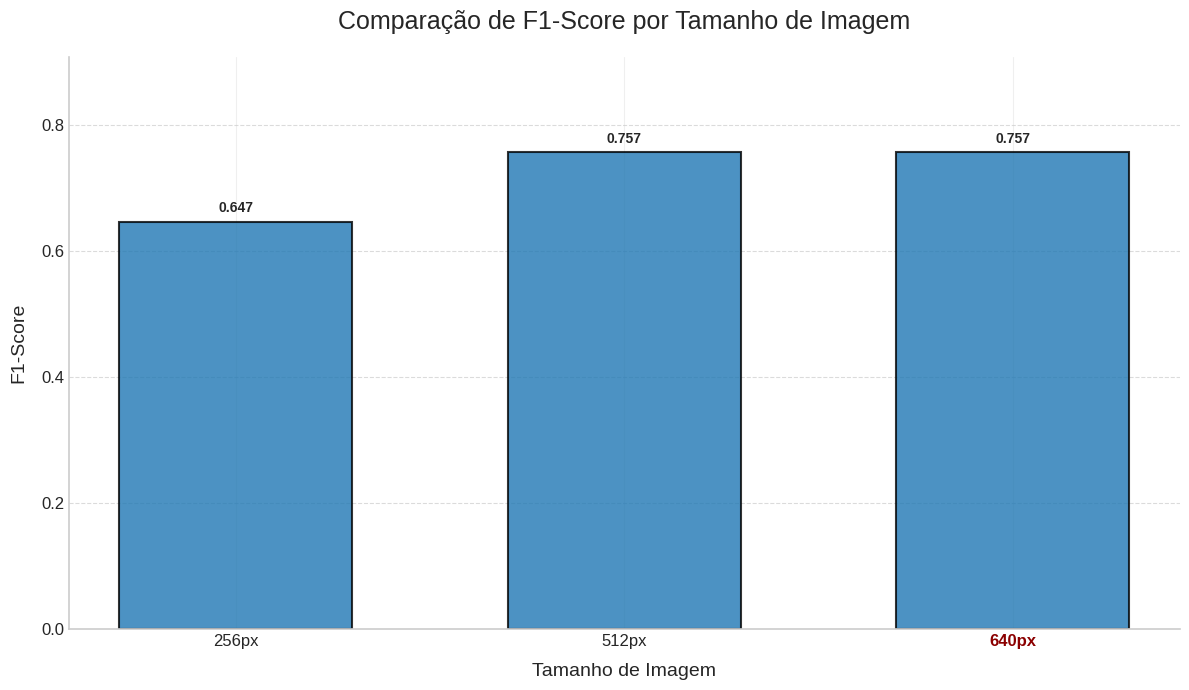

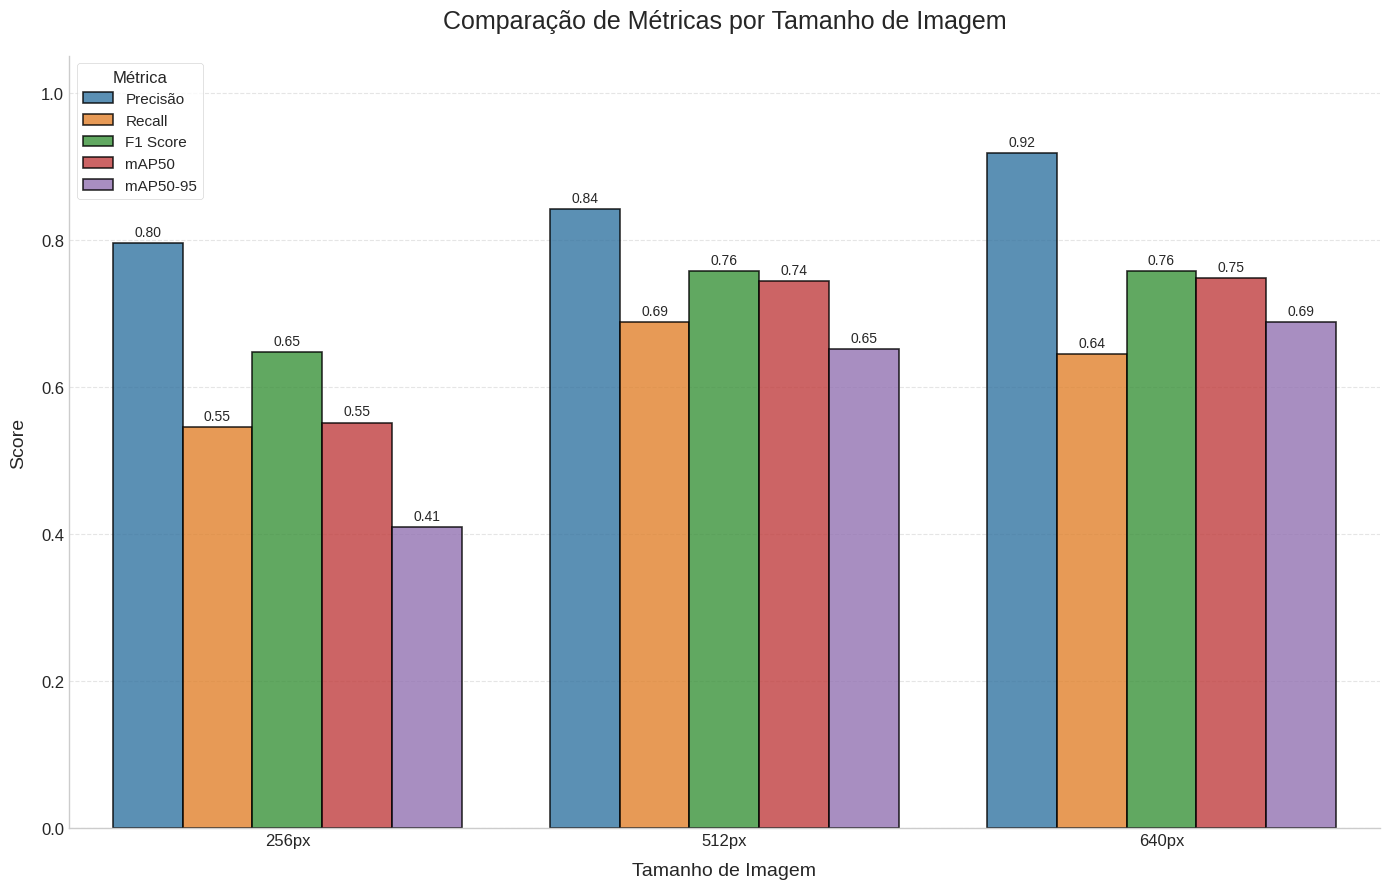

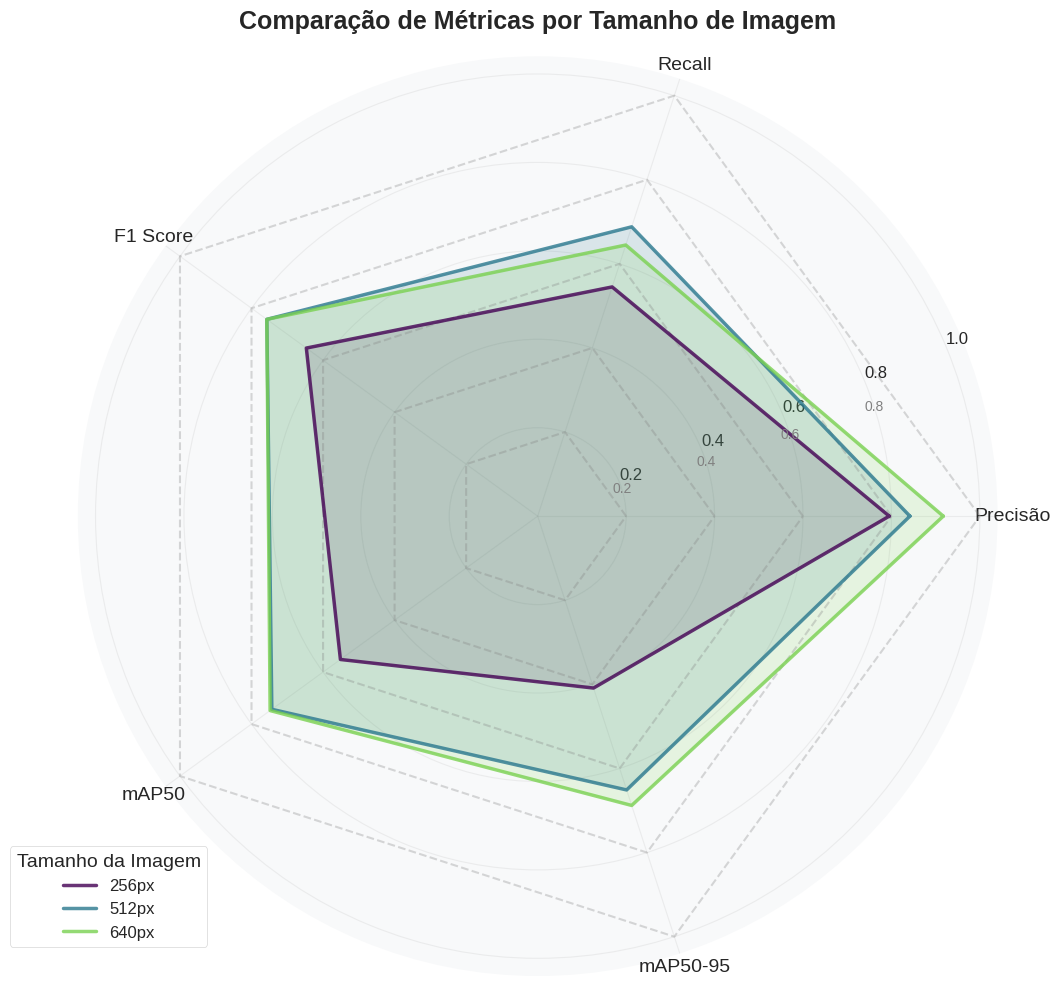


Melhor tamanho de imagem: 640px
F1-score: 0.7572
Precision: 0.9173
Recall: 0.6447
mAP50: 0.7480
mAP50-95: 0.6880


In [13]:
base_dir = '/content/drive/MyDrive/ml_challenge/yolo_project/results/'

if not os.path.exists(base_dir):
      base_dir = os.getcwd()
      print(f"Diretório padrão não encontrado. Usando diretório atual: {base_dir}")

analyze_yolo_models(base_dir)

# Testes em Imagens de Validação

Encontrados 3 modelos:
1. Tamanho 256px: 256px_20250412_012522_best.pt
2. Tamanho 512px: 512px_20250412_013230_best.pt
3. Tamanho 640px: 640px_20250412_014149_best.pt
Modelo carregado: /content/drive/MyDrive/ml_challenge/yolo_project/results/256px/256px_20250412_012522_best.pt
Modelo carregado: /content/drive/MyDrive/ml_challenge/yolo_project/results/512px/512px_20250412_013230_best.pt
Modelo carregado: /content/drive/MyDrive/ml_challenge/yolo_project/results/640px/640px_20250412_014149_best.pt
Encontradas 92 imagens de validação

Testando imagem: /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images/f9a31b56-results_0122.jpg

image 1/1 /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images/f9a31b56-results_0122.jpg: 160x256 1 car, 1 motorcycle, 2 trucks, 14.6ms
Speed: 0.7ms preprocess, 14.6ms inference, 1.9ms postprocess per image at shape (1, 3, 160, 256)

image 1/1 /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/va

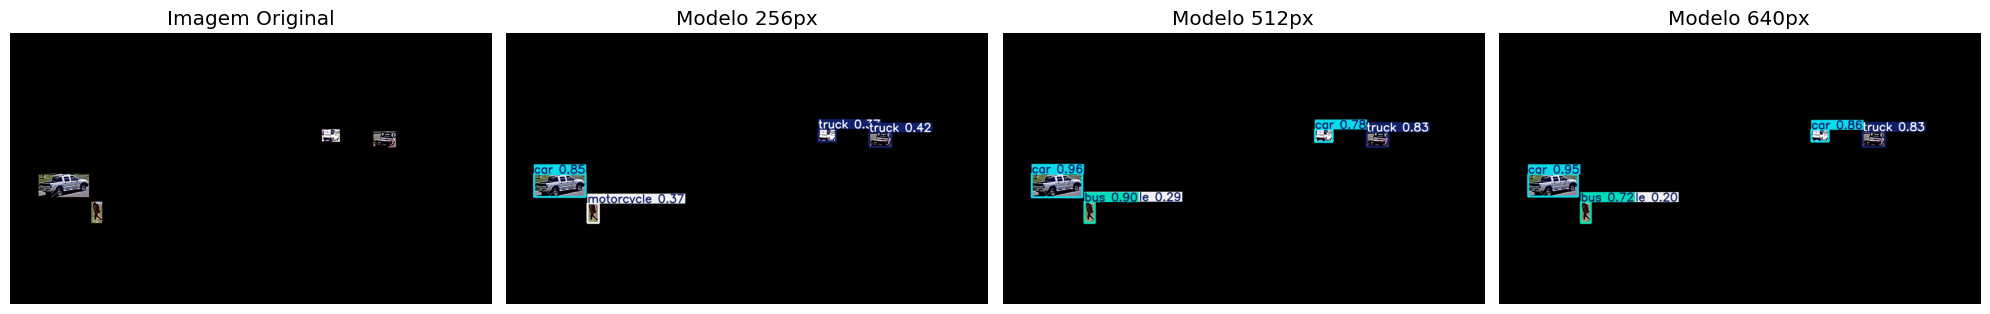


Resultados da amostra 1 (f9a31b56-results_0122.jpg):

image 1/1 /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images/f9a31b56-results_0122.jpg: 160x256 1 car, 1 motorcycle, 2 trucks, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 256)
Modelo 256px:
  - car: 0.853
  - truck: 0.415
  - truck: 0.372
  - motorcycle: 0.370

image 1/1 /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images/f9a31b56-results_0122.jpg: 288x512 2 cars, 1 motorcycle, 1 bus, 1 truck, 9.4ms
Speed: 1.3ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 512)
Modelo 512px:
  - car: 0.964
  - bus: 0.902
  - truck: 0.828
  - car: 0.781
  - motorcycle: 0.290

image 1/1 /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images/f9a31b56-results_0122.jpg: 384x640 2 cars, 1 motorcycle, 1 bus, 1 truck, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.1ms postprocess per image a

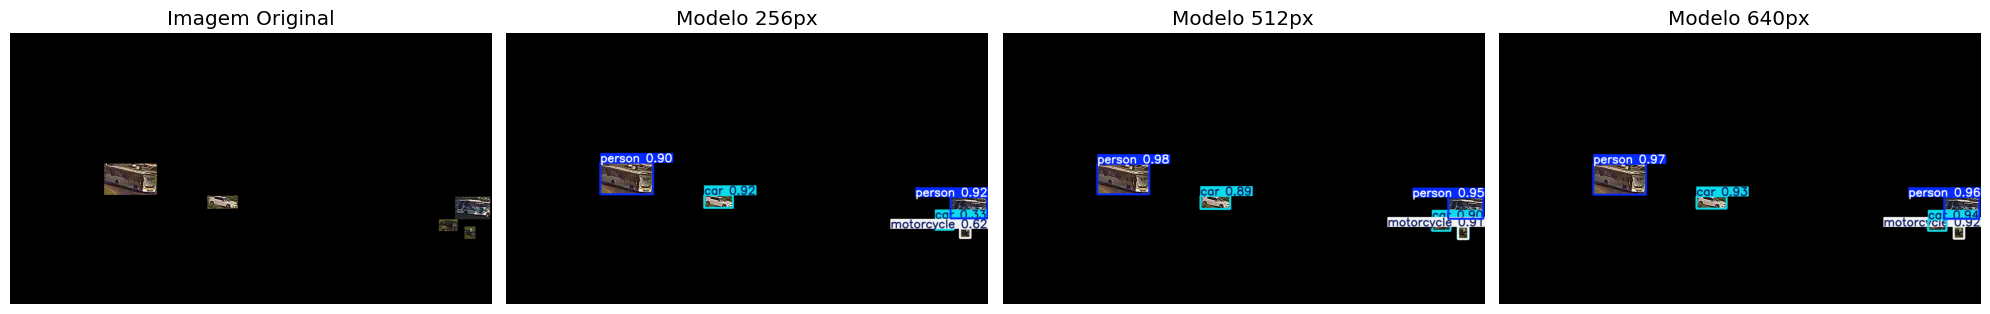


Resultados da amostra 2 (d9b06d05-results_0070.jpg):

image 1/1 /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images/d9b06d05-results_0070.jpg: 160x256 2 persons, 2 cars, 1 motorcycle, 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 256)
Modelo 256px:
  - car: 0.921
  - person: 0.917
  - person: 0.900
  - motorcycle: 0.622
  - car: 0.325

image 1/1 /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images/d9b06d05-results_0070.jpg: 288x512 2 persons, 3 cars, 1 motorcycle, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 512)
Modelo 512px:
  - person: 0.979
  - person: 0.955
  - motorcycle: 0.906
  - car: 0.901
  - car: 0.889
  - car: 0.198

image 1/1 /content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images/d9b06d05-results_0070.jpg: 384x640 2 persons, 2 cars, 1 motorcycle, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference,

In [15]:
def test_models_on_validation(num_samples=5):
    """
    Testa os modelos em algumas imagens de validação para comparação visual,
    carregando os modelos dos arquivos .pt salvos.
    """
    # obter os nomes das classes
    yaml_path = "/content/drive/MyDrive/ml_challenge/yolo_project/yaml/data.yaml"
    if not os.path.exists(yaml_path):
        print(f"Arquivo de configuração YAML não encontrado: {yaml_path}")
        return

    with open(yaml_path, 'r') as f:
        yaml_config = yaml.safe_load(f)

    # diretório base onde os resultados foram salvos
    base_dir = '/content/drive/MyDrive/ml_challenge/yolo_project/results/'

    val_images_dir = Path('/content/drive/MyDrive/ml_challenge/yolo_project/data_train/dataset/val/images')
    if not val_images_dir.exists():
        print(f"Diretório de imagens de validação não encontrado: {val_images_dir}")
        return

    # lista todos os arquivos .pt (pesos dos modelos)
    pt_files = []
    image_sizes = []

    # procura em cada subdiretório específico para cada tamanho de imagem
    for size_dir in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, size_dir)) and size_dir.endswith('px'):
            # extrai o tamanho da imagem do nome do diretório
            try:
                img_size = int(size_dir.replace('px', ''))

                # procura arquivos .pt neste diretório
                for file in os.listdir(os.path.join(base_dir, size_dir)):
                    if file.endswith('.pt') and 'best' in file:
                        pt_files.append(os.path.join(base_dir, size_dir, file))
                        image_sizes.append(img_size)
                        break
            except ValueError:
                continue

    if not pt_files:
        print("Nenhum arquivo de pesos (.pt) encontrado nos diretórios de resultados.")
        return

    print(f"Encontrados {len(pt_files)} modelos:")
    for i, (pt_file, img_size) in enumerate(zip(pt_files, image_sizes)):
        print(f"{i+1}. Tamanho {img_size}px: {os.path.basename(pt_file)}")

    # carrega os modelos
    models = []
    for pt_file in pt_files:
        try:
            model = YOLO(pt_file)
            models.append(model)
            print(f"Modelo carregado: {pt_file}")
        except Exception as e:
            print(f"Erro ao carregar modelo {pt_file}: {e}")
            models.append(None)

    # lista todas as imagens de validação
    val_images = list(val_images_dir.glob('*'))
    if not val_images:
        print("Nenhuma imagem de validação encontrada.")
        return

    print(f"Encontradas {len(val_images)} imagens de validação")

    # seleciona amostras aleatórias
    samples = random.sample(val_images, min(num_samples, len(val_images)))

    for sample_idx, img_path in enumerate(samples):
        print(f"\nTestando imagem: {img_path}")
        fig, axs = plt.subplots(1, len(models) + 1, figsize=(20, 5))

        # mostra a imagem original
        img_original = cv2.imread(str(img_path))
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        axs[0].imshow(img_original)
        axs[0].set_title('Imagem Original')
        axs[0].axis('off')

        for i, (model, img_size) in enumerate(zip(models, image_sizes)):
            if model is not None:
                # realiza a detecção com confiança mais baixa para ver se detecta algo
                results = model(img_path, imgsz=img_size, conf=0.1)  # reduz o limiar de confiança

                img_result = results[0].plot()
                img_result = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)

                axs[i+1].imshow(img_result)
                axs[i+1].set_title(f'Modelo {img_size}px')
                axs[i+1].axis('off')
            else:
                axs[i+1].set_title(f'Modelo {img_size}px - Não disponível')
                axs[i+1].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\nResultados da amostra {sample_idx+1} ({img_path.name}):")
        for i, (model, img_size) in enumerate(zip(models, image_sizes)):
            if model is not None:
                # teste com confiança mais baixa
                results = model(img_path, imgsz=img_size, conf=0.1)

                classes = []
                confidences = []

                for box in results[0].boxes:
                    cls = int(box.cls.item())
                    conf = box.conf.item()
                    cls_name = yaml_config['names'][cls]
                    classes.append(cls_name)
                    confidences.append(conf)

                print(f"Modelo {img_size}px:")
                if classes:
                    for cls, conf in zip(classes, confidences):
                        print(f"  - {cls}: {conf:.3f}")
                else:
                    print("  - Nenhuma detecção")
            else:
                print(f"Modelo {img_size}px: Modelo não disponível")

test_models_on_validation(num_samples=2)